# Práctica 1
---

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import time
import matplotlib.pyplot as plt
import random
import numpy as np
import pickle
import gzip
import os
from time import time

from sklearn.linear_model import LinearRegression

import networkx as nx

## Generación y guardado de grafos
---

In [3]:
def rand_matr_pos_graph(n_nodes, sparse_factor, max_weight=50, decimals=0):
    graph = [[np.inf for i in range(0,n_nodes)] for j in range(0,n_nodes)]
    for i in range(0,n_nodes):
        for j in range(0,n_nodes):
            if i!=j and random.random()<=sparse_factor:
                graph[i][j] = random.randint(1,max_weight)
    return graph


def cuenta_ramas(m_g):
    l=0
    for i in range(0, len(m_g)):
        for j in range(0, len(m_g)):
            if m_g[i][j]<float('inf'):
                l += 1
    return l


def calculate_sparse_factor(g):
    return (cuenta_ramas(g))/(len(g)*(len(g)-1.0))


def check_sparse_factor(n_grafos, n_nodes, sparse_factor):
    values = [calculate_sparse_factor(rand_matr_pos_graph(n_nodes,sparse_factor)) for i in range(0, n_grafos)]
    return sum(values)/(n_grafos)

In [4]:
check_sparse_factor(20, 20, 0.85)

0.8461842105263159

In [5]:
def m_g_2_d_g(m_g):
    graph = {}
    for i in range(0,len(m_g)):
        graph[i] = {}
        for j in range(0, len(m_g)):
            if m_g[i][j] < np.inf:
                graph[i][j] = m_g[i][j]
    return graph


def d_g_2_m_g(d_g):
    graph = [[np.inf for i in range(0,len(d_g))] for j in range(0,len(d_g))]
    for v1 in d_g:
        for v2 in d_g[v1]:
            graph[v1][v2] = d_g[v1][v2]
    return graph

In [6]:
def save_object(obj, f_name='obj.pklz', save_path='.'):
    complete_name = os.path.join(save_path, f_name)
    with gzip.open(complete_name,'wb') as f:
        pickle.dump(obj,f)
        
def read_object(f_name, save_path='.'):
    complete_name = os.path.join(save_path, f_name)
    obj = None
    with gzip.open(complete_name) as f:
        obj = pickle.load(f)
    return obj

In [7]:
# Trivial Graph Format (TGF)
def d_g_2_TGF(d_g, f_name):
    out = ''
    for v1 in d_g:
        out += str(v1)+'\n'
    out += '#\n'
    for v1 in d_g:
        for v2 in d_g[v1]:
            out += str(v1)+' '+str(v2)+' '+str(d_g[v1][v2])+'\n'
    with open(f_name,'w') as f:
        f.write(out)        
        

def TGF_2_d_g(f_name):
    with open(f_name) as f:
        tgf = f.read()
    nodes, edges = tgf.split('#\n')
    nodes = nodes.split('\n')[:-1] # Last is empty
    edges = list(map(lambda x: x.split(' '), edges.split('\n')[:-1]))
    graph = {}
    for node in nodes:
        graph[int(node)] = {}
    for v1, v2, weight in edges:
        graph[int(v1)][int(v2)] = float(weight)
    return graph

## Distancias mínimas en grafos
---

In [8]:
# DIJKSTRA!
from queue import PriorityQueue

def dijkstra_d(d_g, u):
    dist = {}
    prev = {}
    visited = {}
    for ele in d_g:
        dist[ele] = np.inf
        prev[ele] = -1
        visited[ele] = False
    q = PriorityQueue()
    dist[u] = 0
    q.put((0, u))
    while not q.empty():
        w, curr = q.get()
        if not visited[curr]:
            visited[curr] = True
            for node in d_g[curr]:
                if d_g[curr][node]+w < dist[node]:
                    dist[node] = d_g[curr][node]+w
                    prev[node] = curr
                    q.put((dist[node], node))
    return dist, prev
    
    
def dijkstra_m(m_g, u):
    dist = {}
    prev = {}
    visited = {}
    for ele in range(len(m_g)):
        dist[ele] = np.inf
        prev[ele] = -1
        visited[ele] = False
    q = PriorityQueue()
    dist[u] = 0
    q.put((0, u))
    while not q.empty():
        w, curr = q.get()
        if not visited[curr]:
            visited[curr] = True
            for node in range(len(m_g[curr])):
                if m_g[curr][node]+w < dist[node]:
                    dist[node] = m_g[curr][node]+w
                    prev[node] = curr
                    q.put((dist[node], node))
    return dist, prev


def min_path(d_prev, v):
    if d_prev[v]<0:
        return [] # There is no path
    path = [v]
    while d_prev[v]>=0:
        v = d_prev[v]
        path.append(v)
    path.reverse()
    return path    
    
def min_paths(d_prev):
    d_path = {}
    for ele in d_prev:
        d_path[ele] = min_path(d_prev, ele)
    return d_path

In [9]:


def time_dijkstra(n_graphs, n_nodes_ini, n_nodes_fin, step, generate, dijks, sparse_factor=.25):
    times = [] # Returning list
    for nodes in range(n_nodes_ini, n_nodes_fin+1, step):
        meanTime = 0
        for _ in range(n_graphs):
            graph = generate(nodes, sparse_factor) 
            time_ini = time()
            for i in range(nodes):
                dijks(graph,i)
            meanTime += (time()-time_ini)
        times.append(meanTime/n_graphs) # No dividimos por n_nodes porque la aproximación de fit_plot lo toma en cuenta
    return times
    
    
def time_dijkstra_m(n_graphs, n_nodes_ini, n_nodes_fin, step, sparse_factor=.25):
    return time_dijkstra(n_graphs, n_nodes_ini, n_nodes_fin, step, rand_matr_pos_graph, dijkstra_m, sparse_factor=sparse_factor)
    
    
def time_dijkstra_d(n_graphs, n_nodes_ini, n_nodes_fin, step, sparse_factor=.25):
    f = lambda x,y: m_g_2_d_g(rand_matr_pos_graph(x,y))
    return time_dijkstra(n_graphs, n_nodes_ini, n_nodes_fin, step, f, dijkstra_d, sparse_factor=sparse_factor)


In [10]:
## FUNCIONES DEL CUADERNO AUXILIAR (ligeramente modificadas para hacerlas más generales)
def fit_plot(l, func_2_fit, size_ini, size_fin, step, label=None, rho=False, xlabel=None, ylabel=None):
    if not rho:
        x_vals = [i for i in range(size_ini, size_fin+1, step)]
        l_func_values =[i*func_2_fit(i) for i in range(size_ini, size_fin+1, step)]
    else:
        # Para el fitting del rho que requiere de iteración con floats
        # Nota: No  multiplicamos por el número de nodos porque en este caso es cte
        l_func_values =[]
        x_vals = []
        i=size_ini
        while i<=size_fin:
            x_vals.append(i)
            l_func_values.append(func_2_fit(i))
            i += step
        
    lr_m = LinearRegression()
    X = np.array(l_func_values).reshape( len(l_func_values), -1 )
    lr_m.fit(X, l)
    y_pred = lr_m.predict(X)
    
    if label:
        plt.plot(x_vals, l, '*', x_vals, y_pred, '-',label=label)
    else:
        plt.plot(x_vals, l, '*', x_vals, y_pred, '-',label=label)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    

def n2_log_n(n):
    return n**2. * np.log(n)


def print_m_g(m_g):
    print("graph_from_matrix:\n")
    n_v = m_g.shape[0]
    for u in range(n_v):
        for v in range(n_v):
            if v != u and m_g[u, v] != np.inf:
                print("(", u, v, ")", m_g[u, v])
                
                
def print_d_g(d_g):
    print("\ngraph_from_dict:\n")
    for u in d_g.keys():
        for v in d_g[u].keys():
            print("(", u, v, ")", d_g[u][v])

In [11]:
args = [8,10,200,10]

In [12]:
x = [x for x in range(args[1],args[2]+1,args[3])]
y = time_dijkstra_m(*args,sparse_factor=0.9)
y2 = time_dijkstra_d(*args,sparse_factor=0.9)

Comprobación del crecimiento del algoritmo de Dijkstra


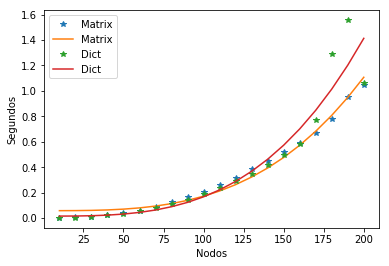

In [13]:
# Plot fitted
fit_plot(y, n2_log_n, *args[1:],label='Matrix', xlabel='Nodos', ylabel='Segundos')
fit_plot(y2, n2_log_n, *args[1:],label='Dict', xlabel='Nodos', ylabel='Segundos')
plt.legend(loc='upper left')
print('Comprobación del crecimiento del algoritmo de Dijkstra')

## Librería NetworkX
---

In [14]:
def edges(d_g):
    e = []
    for u in d_g:
        for v in d_g[u]:
            e.append((u,v,d_g[u][v]))
    return e


def d_g_2_nx_g(d_g):
    g = nx.DiGraph()
    g.add_weighted_edges_from(edges(d_g))
    return g

def nx_g_2_d_g(nx_g):
    d_g = {}
    for u in nx_g:
        d_g[u] = {}
        for v in nx_g[u]:
            d_g[u][v] = nx_g[u][v]['weight']

In [15]:
def time_dijkstra_nx(n_graphs, n_nodes_ini, n_nodes_fin, step, sparse_factor=.25):    
    f = lambda x,y: d_g_2_nx_g(m_g_2_d_g(rand_matr_pos_graph(x,y)))
    return time_dijkstra(n_graphs, n_nodes_ini, n_nodes_fin, step, f, nx.single_source_dijkstra, sparse_factor=sparse_factor)


In [16]:
ynx = time_dijkstra_nx(*args, sparse_factor=0.9)

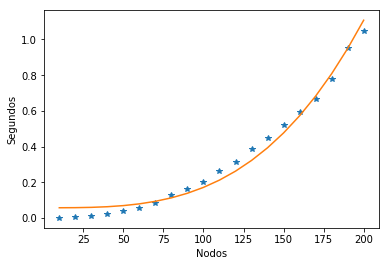

In [17]:
fit_plot(y, n2_log_n, *args[1:],label='Nx', xlabel='Nodos', ylabel='Segundos')


### Apéndice
---
Crecimiento de Dijkstra iterando sobre el _sparse factor_

In [18]:
def time_dijks_rho(rho_ini,rho_fin, step, dijks, generate,n_nodes=100, n_graphs=30, for_all_nodes=True):
    if for_all_nodes: 
        # Iterate Dijkstra for all nodes
        iters = n_nodes
    else:
        # Only dijkstra from 0
        iters = 1
    times = []
    rho = rho_ini
    while rho <= rho_fin:
        mean_time = 0
        for _ in range(n_graphs):
            g = generate(n_nodes, rho)
            time_ini = time()
            for i in range(n_nodes):
                try:
                    dijks(g,i)
                except:
                    pass # If no path is found, just continue with next node
            mean_time += (time()-time_ini)
        times.append(mean_time/n_graphs)
        rho += step
    return times

In [19]:
ini = 0.1
fin = 0.9
step = 0.2
# Fit a line
f = lambda x: x
# For adj lists
dijks = lambda g,i: dijkstra_d(g,i)
generate = lambda n_nodes, sparse_factor: m_g_2_d_g(rand_matr_pos_graph(n_nodes=n_nodes, sparse_factor=sparse_factor))
times_d = time_dijks_rho(ini,fin,step, dijks, generate)
# For Nx Library with no iteration
dijks = lambda g,i: nx.single_source_dijkstra(g,i)
generate = lambda x,y: d_g_2_nx_g(m_g_2_d_g(rand_matr_pos_graph(x,y)))
times_nx = time_dijks_rho(ini,fin,step, dijks, generate, for_all_nodes=False)
# With iteration
times_nx_iter = time_dijks_rho(ini,fin,step, dijks, generate, n_nodes=25)



Lista de adyacencia con 100 nodos fijos desde todos los vértices


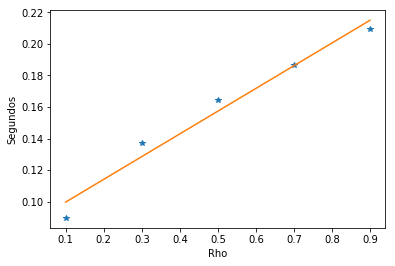

In [20]:
print('Lista de adyacencia con 100 nodos fijos desde todos los vértices')
fit_plot(times_d,func_2_fit=f,size_ini=ini,size_fin=fin,step=step,rho=True, xlabel='Rho', ylabel='Segundos')
plt.savefig('2_2')



Nx con 100 nodos fijos, solo ejecutando Dijkstra una vez


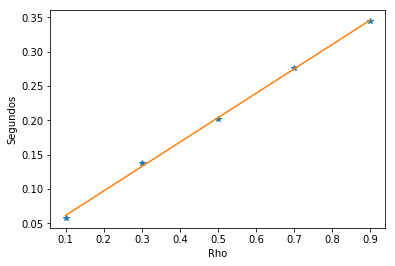

In [21]:
print('Nx con 100 nodos fijos, solo ejecutando Dijkstra una vez')
fit_plot(times_nx,func_2_fit=f,size_ini=ini,size_fin=fin,step=step,rho=True, xlabel='Rho', ylabel='Segundos')
plt.savefig('3_1')


Nx con 25 nodos fijos, ejecutando desde todo nodo


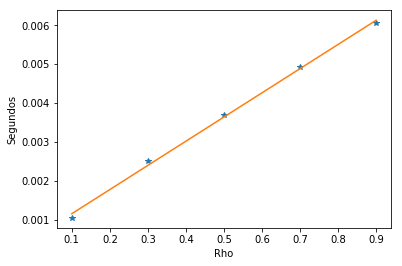

In [22]:
print('Nx con 25 nodos fijos, ejecutando desde todo nodo')
fit_plot(times_nx_iter,func_2_fit=f,size_ini=ini,size_fin=fin,step=step,rho=True, xlabel='Rho', ylabel='Segundos')
plt.savefig('3_2')
